In [5]:
using PyPlot, StatsBase, Printf, DelimitedFiles;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/yasu/.julia/packages/Revise/Pcs5V/src/Revise.jl:1217


### Potential energy function

In [6]:
V(x; k=1.0) = sum(- (1.0 / 2.0) .* k .* x.^2 .+ (1.0 ./ 4.0) .* k .* x.^4)
V([0.0], k=1.0)

0.0

### Proposal distribution

In [7]:
proposal_fun(x) = x .+ (rand(Float64, size(x)) .* 2.0 .- 1.0);
proposal_fun([0.0])

1-element Array{Float64,1}:
 -0.7997181686609052

### Replica MCMC with exchange

In [8]:
function exchange_temperature!(m2i, i2m, icount, x_replica, pot_fun::Function, temperature_replica)
    nreplica = length(x_replica)

    m_array = 1:nreplica
    t_array = temperature_replica[m_array]
    b_array = 1.0 ./ t_array
    i_array = m2i[m_array]
    v_array = map(pot_fun, x_replica[i_array])
    
    if mod(icount, 2) == 0
        m_lower = 1:2:(nreplica-1)
        m_higher = 2:2:nreplica
    else
        m_lower = 2:2:(nreplica-1)
        m_higher = 3:2:nreplica
    end
    
    iaccepted = 0
    for ipair = 1:length(m_higher)
        m1 = m_lower[ipair]
        m2 = m_higher[ipair]
        delta = (b_array[m2] - b_array[m1]) * (v_array[m1] - v_array[m2])
        if exp(-delta) > rand()
            m2i[m_array[m1]], m2i[m_array[m2]] = m2i[m_array[m2]], m2i[m_array[m1]]
            i2m[i_array[m1]], i2m[i_array[m2]] = i2m[i_array[m2]], i2m[i_array[m1]]
            iaccepted += 1
        end
    end

    return iaccepted / length(m_higher)
end

exchange_temperature! (generic function with 1 method)

In [11]:
nreplica = 4
temperature_replica = [0.01, 0.10, 0.30, 0.40];
nstep = 100;
nexchange = 20;
m2i = collect(1:nreplica)
i2m = collect(1:nreplica)

x_replica = []
for i = 1:nreplica
    x = [0.0]
    push!(x_replica, x)
end

io_replica = []
for i = 1:nreplica
    filename = "replica$(i).dat"
    io = open(filename, "w")
    push!(io_replica, io)
end

icount = 0
acceptance_ratio = 0.0
for iexchange = 1:nexchange
    for i = 1:nreplica
        x_replica[i] = propagate_mcmc(y -> V(y, k=1.0), proposal_fun, x_replica[i], temperature_replica[i2m[i]], nstep=nstep, io=io_replica[i]);
    end
    # do exchange
    acceptance_ratio += exchange_temperature!(m2i, i2m, icount, x_replica, y -> V(y, k=1.0), temperature_replica)
    icount += 1
end

for i = 1:nreplica
    close(io_replica[i])
end

acceptance_ratio = acceptance_ratio / nexchange

0.775

### Trajectory analysis

In [22]:
traj_replica = []
temp_replica = []

for i = 1:nreplica
    filename = "replica$(i).dat"
    data = readdlm(filename);
    push!(temp_replica, data[:, 1])
    push!(traj_replica, data[:, 2])
end

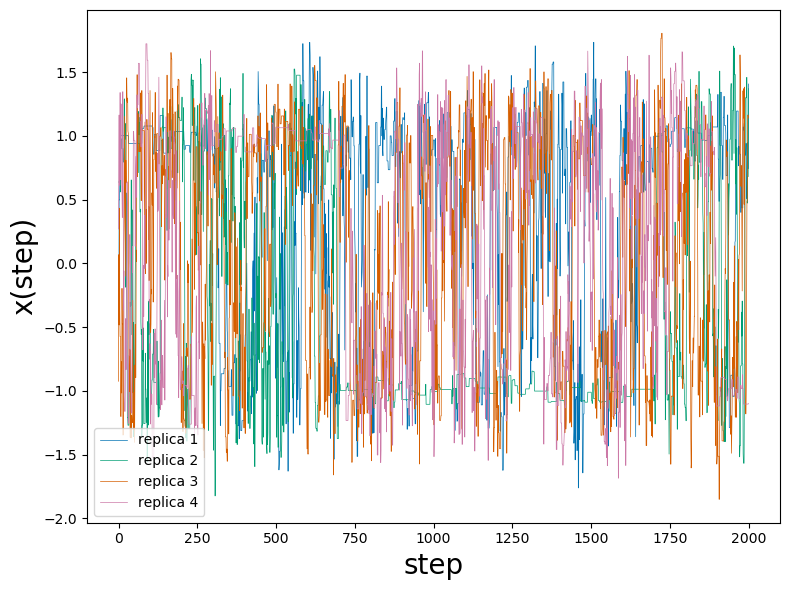

In [23]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_replica[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

In [52]:
# sort trajectories according to temperature
function sort_traj(traj_replica, temp_replica)
    traj_sorted = deepcopy(traj_replica)
    temp_sorted = deepcopy(temp_replica)
    nframe = size(traj_replica[1], 1)
    for iframe = 1:nframe
        temp_snapshot = map(x -> x[iframe], temp_replica)
        p = sortperm(temp_snapshot)
        for m = 1:nreplica
            traj_sorted[m][iframe, :] .= traj_replica[p[m]][iframe, :]
            temp_sorted[m][iframe, :] .= temp_replica[p[m]][iframe, :]
        end
    end
    return traj_sorted, temp_sorted
end

sort_traj (generic function with 1 method)

In [53]:
traj_sorted, temp_sorted = sort_traj(traj_replica, temp_replica)

(Any[[-0.336679, -0.336679, 0.498394, 0.498394, 0.611046, 1.060089, 1.060089, 1.002149, 1.002149, 1.002149  …  -1.103148, -1.103148, -1.103148, -1.103148, -1.103148, -1.103148, -1.103148, -1.103148, -1.103148, -1.098996], [0.638805, 0.638805, 0.638805, 0.638805, 0.65123, 0.65123, 0.560305, 0.978444, 0.978444, 0.978444  …  0.848653, 0.941681, 0.941681, 0.529124, 0.505135, 0.735073, 0.947917, 0.743068, 0.743068, 1.407651], [-0.924264, 0.069709, -0.482843, 0.433642, -0.370006, -0.573566, -0.573566, -1.20069, -1.20069, -0.771929  …  1.29924, 1.29924, 1.29924, 1.459189, 1.459189, 0.473114, 0.681015, 0.681015, 0.681015, 1.372011], [0.270299, 1.162845, 1.162845, 1.162845, 0.612273, 1.34078, 0.656858, 1.250017, 1.250017, 1.250017  …  -1.179768, -1.179768, -0.963077, -0.321212, 0.489919, 0.489919, 1.16362, 1.16362, 1.16362, 1.140401]], Any[[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01  …  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0

In [60]:
temp_sorted[1]

2000-element Array{Float64,1}:
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 ⋮
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01

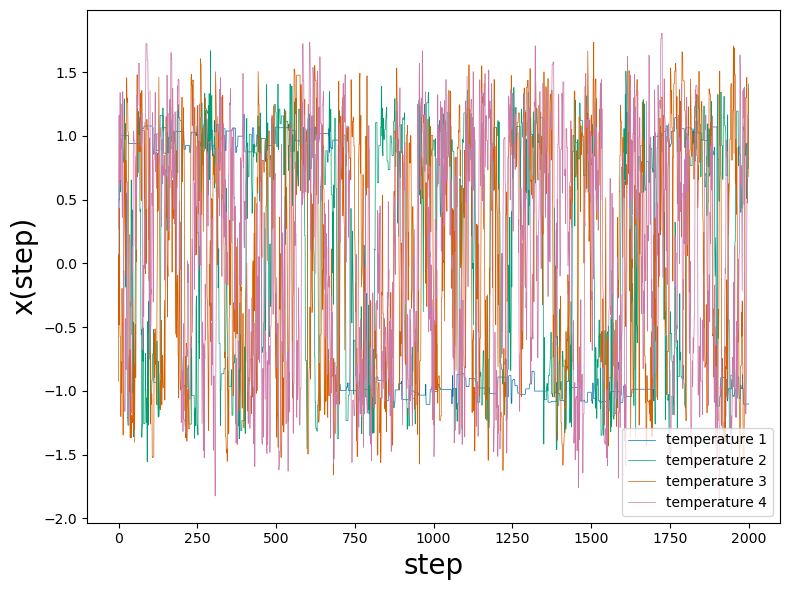

In [61]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_sorted[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["temperature 1", "temperature 2", "temperature 3", "temperature 4"])
tight_layout()

In [62]:
x_grid = range(-1.3, 1.3, length=100);
pmf_theory = V.(x_grid, k=1) ./ temperature_replica[1]
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [63]:
pmf_observed, _ = getpmf(traj_sorted[1], grid_x = collect(x_grid), bandwidth=0.05);

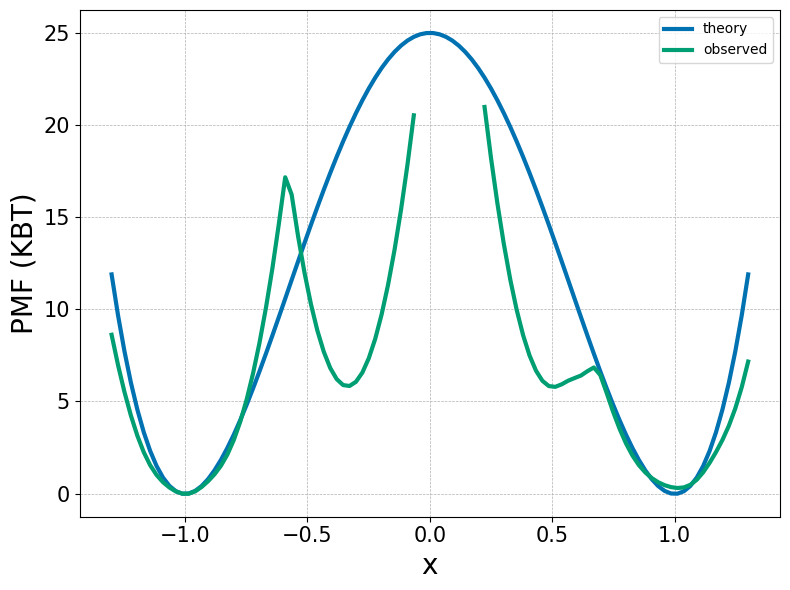

In [65]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("mcmc_replica_exchange.png", dpi=350)